In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Time Series Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Warnings & display
import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format


c:\Users\FV586VH\Downloads\VSC\Model\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
train_df = pd.read_parquet("FY24FY25.parquet")
test_df  = pd.read_parquet("FY26.parquet")

df = pd.concat([train_df, test_df], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (2986151, 24)


,ANSR / Tech Revenue FYTD,AR Outstanding,Billed Expenses FYTD,Billed Fees FYTD,Billed Revenue Days,Charged Hours FYTD,Client,Client ID,EAF Reserve FYTD,ETD Total Collections,...,FYTD Labor Costs,FYTD Unbilled Expenses,Location,MS,NUI ETD,Total Billed FYTD,Unbilled Revenue Days,Month,Week,Year
0,0.00,0.00,0.00,0.00,0.00,0.00,QUEST GLOBAL SERVICES PTE. LTD.,11421164,0.00,0.00,...,0.00,0.00,Bangalore,TMT,0.00,0.00,0.00,03 Sep,10,FY24
1,0.00,0.00,0.00,0.00,0.00,0.00,Industrial Energy Limited,11881305,0.00,0.00,...,0.00,0.00,East,IIC,0.00,0.00,0.00,03 Sep,10,FY24
2,0.00,0.00,0.00,0.00,0.00,0.00,Vini Cosmetics Private Limited,11453641,0.00,0.00,...,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24
3,0.00,0.00,0.00,0.00,0.00,0.00,UNIPHORE SOFTWARE SYSTEMS PRIVATE LIMITED,12239544,0.00,0.00,...,0.00,0.00,Delhi,TMT,0.00,0.00,0.00,03 Sep,10,FY24
4,0.00,0.00,0.00,0.00,0.00,0.00,THE TATA POWER COMPANY LIMITED,11230405,0.00,0.00,...,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24


In [3]:
weekly_df = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Week"])
)

# Convert FY → numeric year
weekly_df["Year_Num"] = (
    weekly_df["Year"]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(int) + 2000
)

# Create Monday date for each fiscal week
weekly_df["Date"] = pd.to_datetime(
    weekly_df["Year_Num"].astype(str) +
    weekly_df["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)

weekly_df = weekly_df.sort_values("Date").set_index("Date")
weekly_df.head()


,Year,Week,ANSR / Tech Revenue FYTD,Year_Num
Date,,,,
2024-01-08,FY24,2,"595,146,955.74",2024
2024-01-15,FY24,3,"896,384,585.76",2024
2024-01-22,FY24,4,"1,255,661,249.62",2024
2024-02-05,FY24,6,"2,007,916,702.01",2024
2024-02-12,FY24,7,"2,286,815,056.52",2024


In [4]:
weekly_df["Weekly_Increment"] = (
    weekly_df["ANSR / Tech Revenue FYTD"]
    .diff()
    .fillna(0)
)

ts_fytd   = weekly_df["ANSR / Tech Revenue FYTD"]
ts_growth = weekly_df["Weekly_Increment"]

ts_growth.describe()


count               111.00
mean         43,638,790.50
std       6,241,534,350.15
min     -41,289,617,487.80
25%         311,439,634.60
50%         441,060,419.74
75%         762,730,331.15
max      26,625,649,417.70
Name: Weekly_Increment, dtype: float64

In [9]:
import pandas as pd

train_df = pd.read_parquet("FY24FY25.parquet")
test_df  = pd.read_parquet("FY26.parquet")

df = pd.concat([train_df, test_df], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (2986151, 24)


,ANSR / Tech Revenue FYTD,AR Outstanding,Billed Expenses FYTD,Billed Fees FYTD,Billed Revenue Days,Charged Hours FYTD,Client,Client ID,EAF Reserve FYTD,ETD Total Collections,...,FYTD Labor Costs,FYTD Unbilled Expenses,Location,MS,NUI ETD,Total Billed FYTD,Unbilled Revenue Days,Month,Week,Year
0,0.00,0.00,0.00,0.00,0.00,0.00,QUEST GLOBAL SERVICES PTE. LTD.,11421164,0.00,0.00,...,0.00,0.00,Bangalore,TMT,0.00,0.00,0.00,03 Sep,10,FY24
1,0.00,0.00,0.00,0.00,0.00,0.00,Industrial Energy Limited,11881305,0.00,0.00,...,0.00,0.00,East,IIC,0.00,0.00,0.00,03 Sep,10,FY24
2,0.00,0.00,0.00,0.00,0.00,0.00,Vini Cosmetics Private Limited,11453641,0.00,0.00,...,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24
3,0.00,0.00,0.00,0.00,0.00,0.00,UNIPHORE SOFTWARE SYSTEMS PRIVATE LIMITED,12239544,0.00,0.00,...,0.00,0.00,Delhi,TMT,0.00,0.00,0.00,03 Sep,10,FY24
4,0.00,0.00,0.00,0.00,0.00,0.00,THE TATA POWER COMPANY LIMITED,11230405,0.00,0.00,...,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24


In [10]:
df.shape

(2986151, 24)

In [12]:
pd.set_option("display.max_columns", None)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Aggregate weekly FYTD
weekly = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

# Sort properly
weekly = weekly.sort_values(["Year", "Week"])

# Compute weekly increment
weekly["Weekly_Increment"] = weekly.groupby("Year")["ANSR / Tech Revenue FYTD"].diff()

# Fix Week 1 reset
weekly.loc[weekly["Week"] == 1, "Weekly_Increment"] = \
    weekly.loc[weekly["Week"] == 1, "ANSR / Tech Revenue FYTD"]

# Separate FY24 & FY25
fy24 = weekly[weekly["Year"].astype(str).str.contains("24")][["Week", "Weekly_Increment"]]
fy25 = weekly[weekly["Year"].astype(str).str.contains("25")][["Week", "Weekly_Increment"]]

# Rename for merge
fy24 = fy24.rename(columns={"Weekly_Increment": "FY24"})
fy25 = fy25.rename(columns={"Weekly_Increment": "FY25"})

# Merge on week number
yoy = pd.merge(fy24, fy25, on="Week", how="inner").sort_values("Week")

# Compute YoY difference
yoy["Diff"] = yoy["FY25"] - yoy["FY24"]

yoy.head(100)


,Week,FY24,FY25,Diff
0,2,NaN,NaN,NaN
1,3,"301,237,630.02","-41,289,617,487.80","-41,590,855,117.82"
2,4,"359,276,663.86","944,122,772.36","584,846,108.50"
3,6,"752,255,452.39","745,437,972.76","-6,817,479.63"
4,7,"278,898,354.51","639,267,861.92","360,369,507.41"
5,8,"337,394,142.88","740,003,772.98","402,609,630.10"
6,9,"353,831,096.53","1,118,573,541.38","764,742,444.85"
7,10,"299,681,967.06","645,393,550.26","345,711,583.20"
8,12,"639,227,314.40","925,823,822.20","286,596,507.80"
9,13,"331,817,166.83","1,021,181,938.92","689,364,772.09"


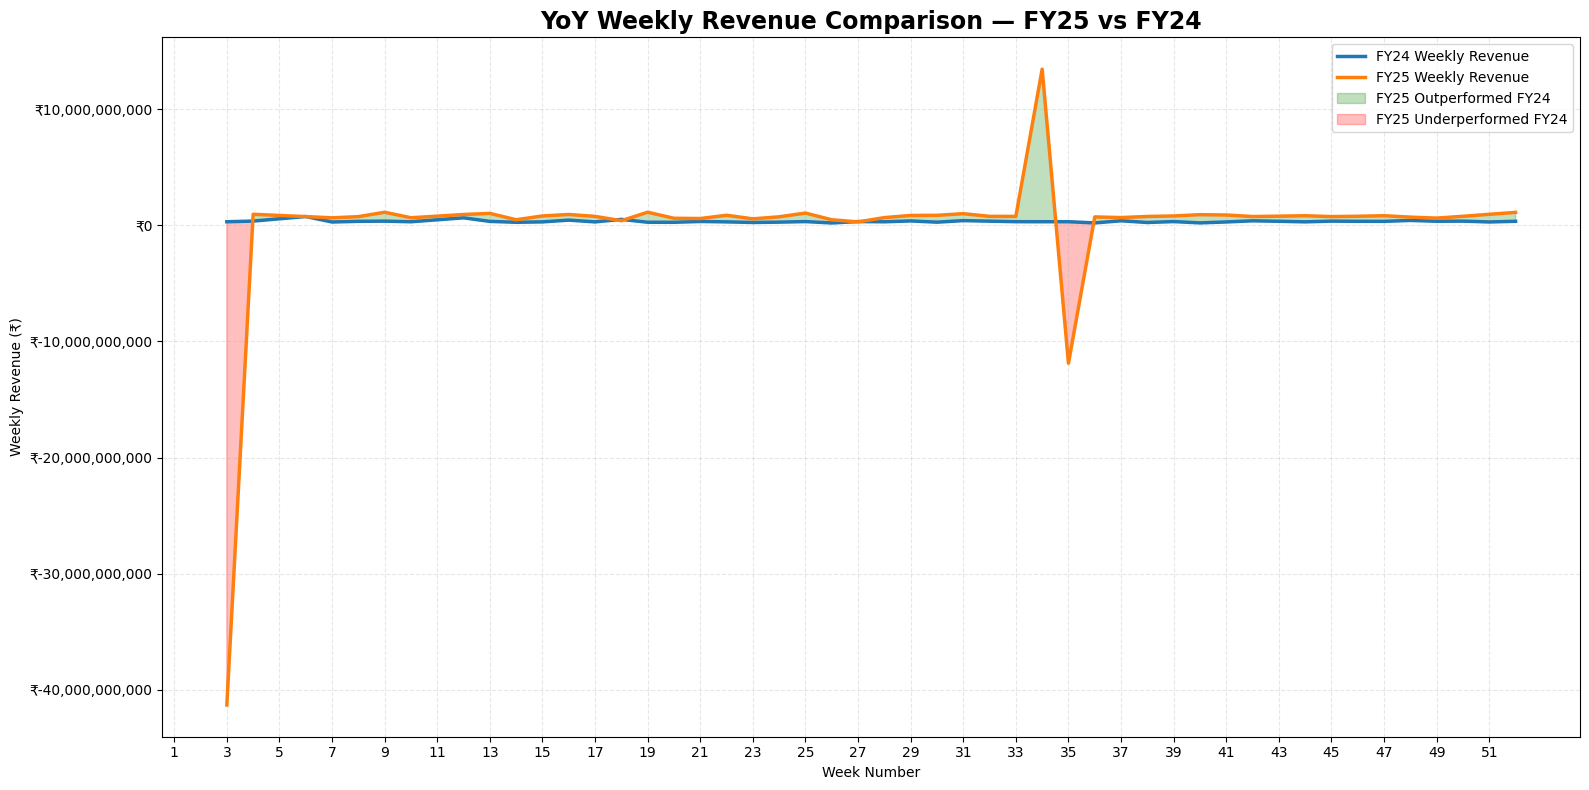

In [24]:
plt.figure(figsize=(16,8))

# Plot FY24 & FY25
plt.plot(yoy["Week"], yoy["FY24"], label="FY24 Weekly Revenue", linewidth=2.5)
plt.plot(yoy["Week"], yoy["FY25"], label="FY25 Weekly Revenue", linewidth=2.5)

# Highlight outperform weeks (FY25 > FY24)
plt.fill_between(
    yoy["Week"],
    yoy["FY24"],
    yoy["FY25"],
    where=(yoy["FY25"] > yoy["FY24"]),
    interpolate=True,
    color="green",
    alpha=0.25,
    label="FY25 Outperformed FY24"
)

# Highlight underperform weeks (FY25 < FY24)
plt.fill_between(
    yoy["Week"],
    yoy["FY24"],
    yoy["FY25"],
    where=(yoy["FY25"] < yoy["FY24"]),
    interpolate=True,
    color="red",
    alpha=0.25,
    label="FY25 Underperformed FY24"
)

# Formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))
plt.title(
    "YoY Weekly Revenue Comparison — FY25 vs FY24",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number")
plt.ylabel("Weekly Revenue (₹)")
plt.xticks(range(1, 53, 2))
plt.grid(alpha=0.3, linestyle="--")
plt.legend(frameon=True)

plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

# Aggregate FYTD by Year & Week
weekly = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Week"])
)

# Compute weekly actual revenue correctly
weekly["Weekly_Actual"] = weekly.groupby("Year")["ANSR / Tech Revenue FYTD"].diff()

# Fix reset week (Week 1)
weekly.loc[weekly["Week"] == 1, "Weekly_Actual"] = \
    weekly.loc[weekly["Week"] == 1, "ANSR / Tech Revenue FYTD"]

weekly.head()


,Year,Week,ANSR / Tech Revenue FYTD,Weekly_Actual
0,FY24,2,"595,146,955.74",NaN
1,FY24,3,"896,384,585.76","301,237,630.02"
2,FY24,4,"1,255,661,249.62","359,276,663.86"
3,FY24,6,"2,007,916,702.01","752,255,452.39"
4,FY24,7,"2,286,815,056.52","278,898,354.51"


In [ ]:
import pandas as pd

# Aggregate FYTD weekly
weekly_fytd = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Week"])
)

# Separate FY24 & FY25
fy24 = weekly_fytd[weekly_fytd["Year"].astype(str).str.contains("24")][["Week", "ANSR / Tech Revenue FYTD"]]
fy25 = weekly_fytd[weekly_fytd["Year"].astype(str).str.contains("25")][["Week", "ANSR / Tech Revenue FYTD"]]

fy24 = fy24.rename(columns={"ANSR / Tech Revenue FYTD": "FY24_FYTD"})
fy25 = fy25.rename(columns={"ANSR / Tech Revenue FYTD": "FY25_FYTD"})

# Merge by Week Number
yoy_fytd = pd.merge(fy24, fy25, on="Week", how="inner").sort_values("Week")

# Difference
yoy_fytd["FYTD_Diff"] = yoy_fytd["FY25_FYTD"]
yoy_fytd["FYTD_Diff"] -= yoy_fytd["FY24_FYTD"]

# Format for readability
yoy_fytd = yoy_fytd.round(2)

yoy_fytd.head(55)


,Week,FY24_FYTD,FY25_FYTD,FYTD_Diff
0,2,"595,146,955.74","43,122,524,857.34","42,527,377,901.60"
1,3,"896,384,585.76","1,832,907,369.54","936,522,783.78"
2,4,"1,255,661,249.62","2,777,030,141.90","1,521,368,892.28"
3,6,"2,007,916,702.01","4,374,179,009.44","2,366,262,307.43"
4,7,"2,286,815,056.52","5,013,446,871.36","2,726,631,814.84"
5,8,"2,624,209,199.40","5,753,450,644.34","3,129,241,444.94"
6,9,"2,978,040,295.93","6,872,024,185.72","3,893,983,889.79"
7,10,"3,277,722,262.99","7,517,417,735.98","4,239,695,472.99"
8,12,"3,916,949,577.39","9,233,925,336.06","5,316,975,758.67"
9,13,"4,248,766,744.22","10,255,107,274.98","6,006,340,530.76"


In [30]:
yoy_fytd.head(55)


,Week,FY24_FYTD,FY25_FYTD,FYTD_Diff
0,2,"595,146,955.74","43,122,524,857.34","42,527,377,901.60"
1,3,"896,384,585.76","1,832,907,369.54","936,522,783.78"
2,4,"1,255,661,249.62","2,777,030,141.90","1,521,368,892.28"
3,6,"2,007,916,702.01","4,374,179,009.44","2,366,262,307.43"
4,7,"2,286,815,056.52","5,013,446,871.36","2,726,631,814.84"
5,8,"2,624,209,199.40","5,753,450,644.34","3,129,241,444.94"
6,9,"2,978,040,295.93","6,872,024,185.72","3,893,983,889.79"
7,10,"3,277,722,262.99","7,517,417,735.98","4,239,695,472.99"
8,12,"3,916,949,577.39","9,233,925,336.06","5,316,975,758.67"
9,13,"4,248,766,744.22","10,255,107,274.98","6,006,340,530.76"


In [29]:
yoy_fytd["FY24_FYTD"].sum()

431480254585.89

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Weekly FYTD aggregation
weekly_fytd = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

# Keep only valid weeks
weekly_fytd = weekly_fytd[weekly_fytd["Week"].between(1, 52)]


In [32]:
# Compute upper bound (99th percentile)
upper_cap = weekly_fytd["ANSR / Tech Revenue FYTD"].quantile(0.99)

# Filter out extreme spikes
weekly_fytd_clean = weekly_fytd[
    weekly_fytd["ANSR / Tech Revenue FYTD"] <= upper_cap
].copy()

print("Removed outliers above:", f"₹{upper_cap:,.0f}")


Removed outliers above: ₹39,745,748,511


In [33]:
fy24 = weekly_fytd_clean[
    weekly_fytd_clean["Year"].astype(str).str.contains("24")
][["Week", "ANSR / Tech Revenue FYTD"]]

fy25 = weekly_fytd_clean[
    weekly_fytd_clean["Year"].astype(str).str.contains("25")
][["Week", "ANSR / Tech Revenue FYTD"]]

fy24 = fy24.rename(columns={"ANSR / Tech Revenue FYTD": "FY24"})
fy25 = fy25.rename(columns={"ANSR / Tech Revenue FYTD": "FY25"})


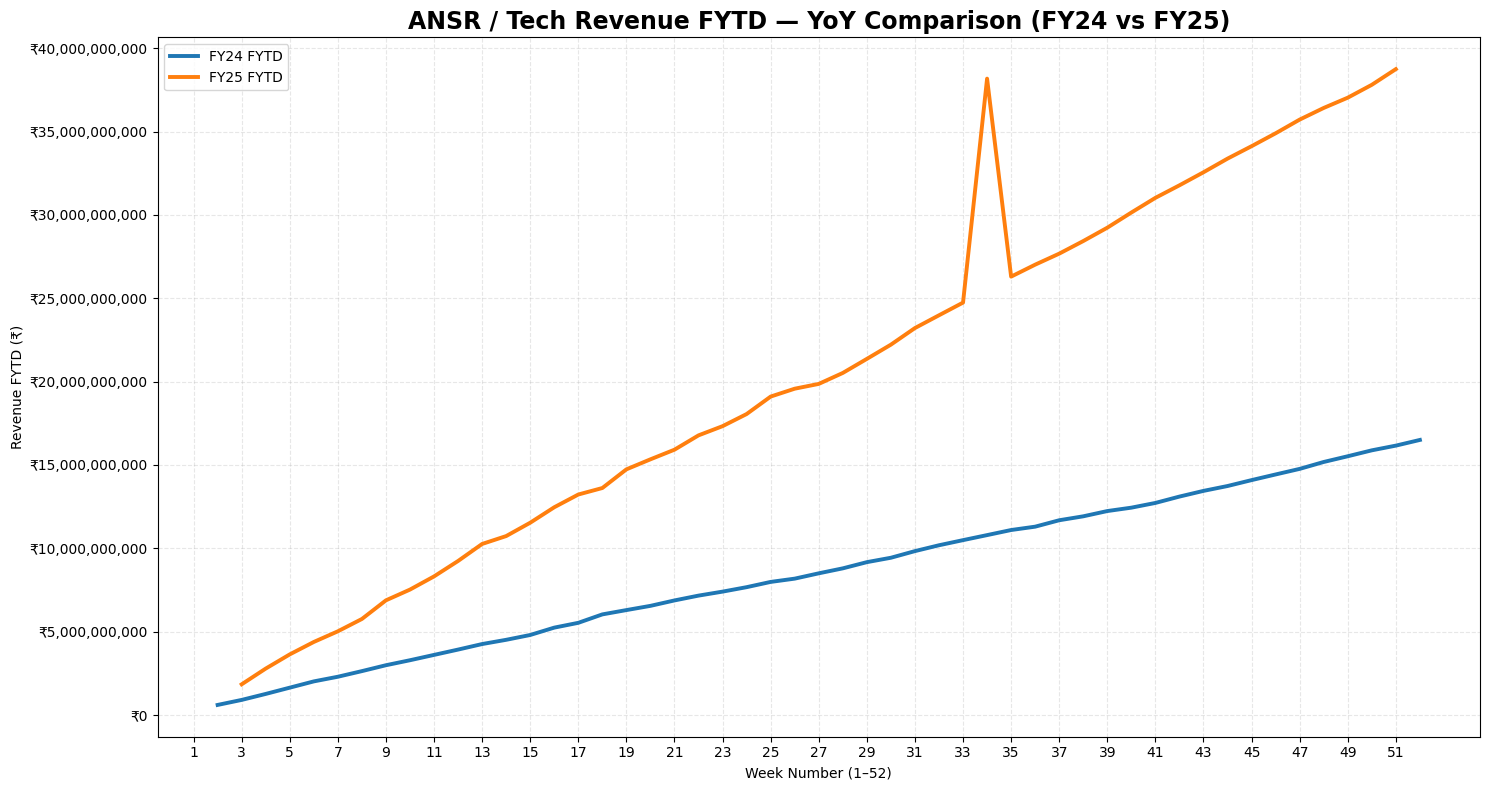

In [36]:
plt.figure(figsize=(15,8))

plt.plot(
    fy24["Week"],
    fy24["FY24"],
    label="FY24 FYTD",
    linewidth=2.8
)

plt.plot(
    fy25["Week"],
    fy25["FY25"],
    label="FY25 FYTD",
    linewidth=2.8
)

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))

plt.title(
    "ANSR / Tech Revenue FYTD — YoY Comparison (FY24 vs FY25)",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number (1–52)")
plt.ylabel("Revenue FYTD (₹)")
plt.xticks(range(1, 53, 2))
plt.grid(alpha=0.3, linestyle="--")
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
# Sort by week
fy25 = fy25.sort_values("Week").copy()

# Rolling median to remove spikes (window=3 is ideal)
fy25["FY25_Clean"] = (
    fy25["FY25"]
    .rolling(window=3, center=True)
    .median()
)

# Fill edges (first & last rows)
fy25["FY25_Clean"] = fy25["FY25_Clean"].fillna(fy25["FY25"])



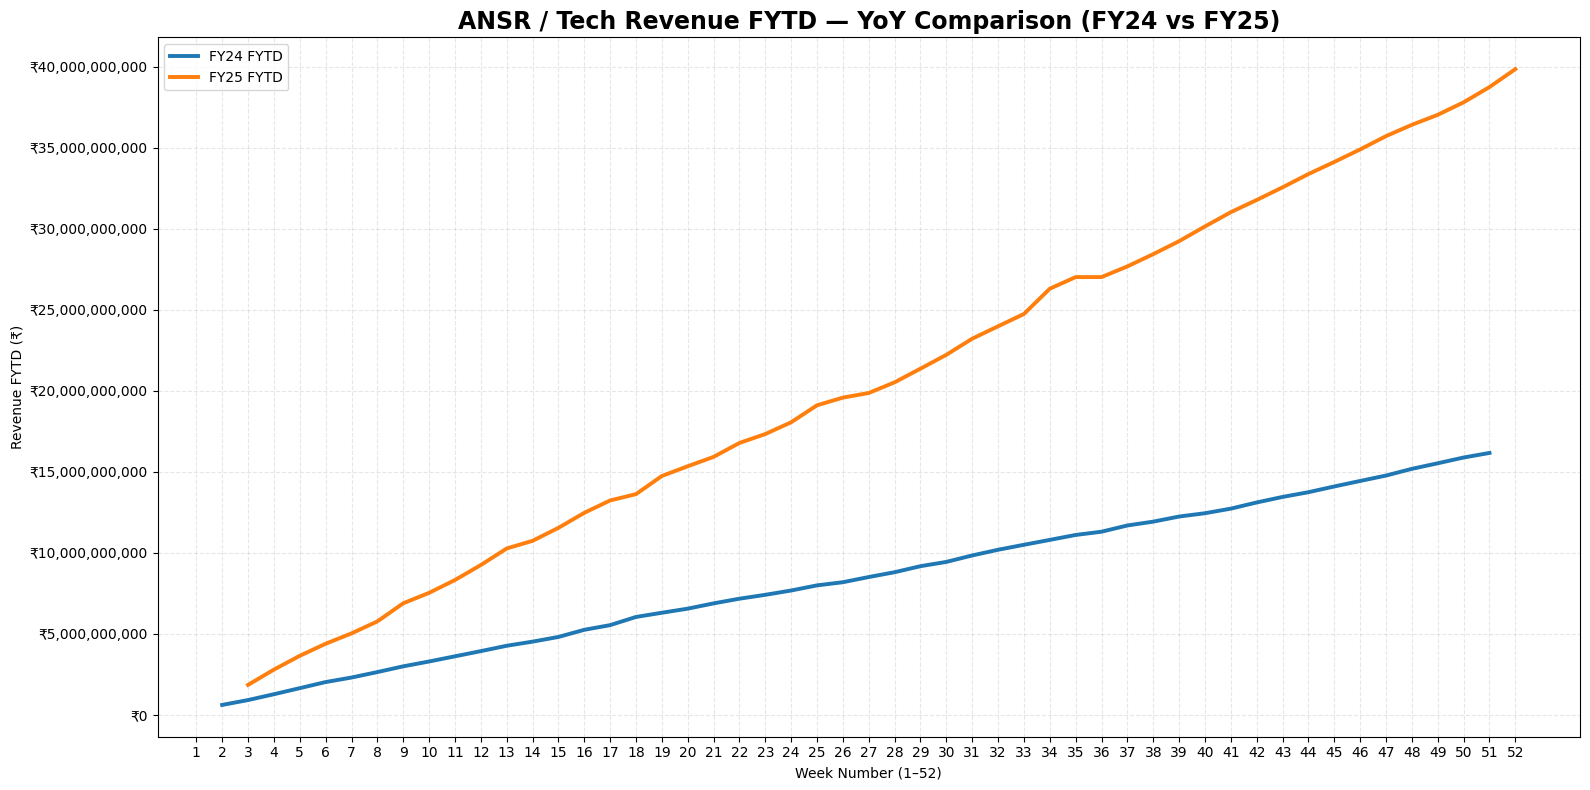

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(16,8))

# FY24
plt.plot(
    fy24["Week"],
    fy24["FY24"],
    label="FY24 FYTD",
    linewidth=2.8
)

# FY25 (spike-adjusted)
plt.plot(
    fy25["Week"],
    fy25["FY25_Clean"],
    label="FY25 FYTD",
    linewidth=2.8
)

# Formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))
plt.title(
    "ANSR / Tech Revenue FYTD — YoY Comparison (FY24 vs FY25)",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number (1–52)")
plt.ylabel("Revenue FYTD (₹)")

# ✅ ALL week numbers, no gaps
plt.xticks(range(1, 53), rotation=0)

plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
# Aggregate weekly FYTD
weekly_fytd = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

# Keep valid weeks only
weekly_fytd = weekly_fytd[weekly_fytd["Week"].between(1, 52)]


In [46]:
fy24 = weekly_fytd[weekly_fytd["Year"].astype(str).str.contains("24")][["Week", "ANSR / Tech Revenue FYTD"]]
fy25 = weekly_fytd[weekly_fytd["Year"].astype(str).str.contains("25")][["Week", "ANSR / Tech Revenue FYTD"]]
fy26 = weekly_fytd[weekly_fytd["Year"].astype(str).str.contains("26")][["Week", "ANSR / Tech Revenue FYTD"]]

fy24 = fy24.rename(columns={"ANSR / Tech Revenue FYTD": "FY24"})
fy25 = fy25.rename(columns={"ANSR / Tech Revenue FYTD": "FY25"})
fy26 = fy26.rename(columns={"ANSR / Tech Revenue FYTD": "FY26"})


In [47]:
def rolling_median_clean(series, window=3):
    clean = series.sort_index().rolling(window=window, center=True).median()
    return clean.fillna(series)

fy25 = fy25.sort_values("Week")
fy26 = fy26.sort_values("Week")

fy25["FY25_Clean"] = rolling_median_clean(fy25["FY25"])
fy26["FY26_Clean"] = rolling_median_clean(fy26["FY26"])



In [49]:
def clean_fytd_series(series, window=3):
    """
    Removes local spikes using rolling median,
    including early-week abnormal jumps.
    """
    s = series.copy()

    # Rolling median (handles mid-series spikes)
    s_clean = s.rolling(window=window, center=True).median()

    # Fill NaNs at edges
    s_clean = s_clean.fillna(s)

    # Extra safety: cap first 3 weeks using median of weeks 3–6
    early_cap = s.iloc[2:6].median()
    s_clean.iloc[0:2] = early_cap

    return s_clean


In [50]:
# FY25
fy25 = fy25.sort_values("Week")
fy25["FY25_Clean"] = clean_fytd_series(fy25["FY25"])

# FY26 (same logic, but partial year)
fy26 = fy26.sort_values("Week")
fy26["FY26_Clean"] = clean_fytd_series(fy26["FY26"])


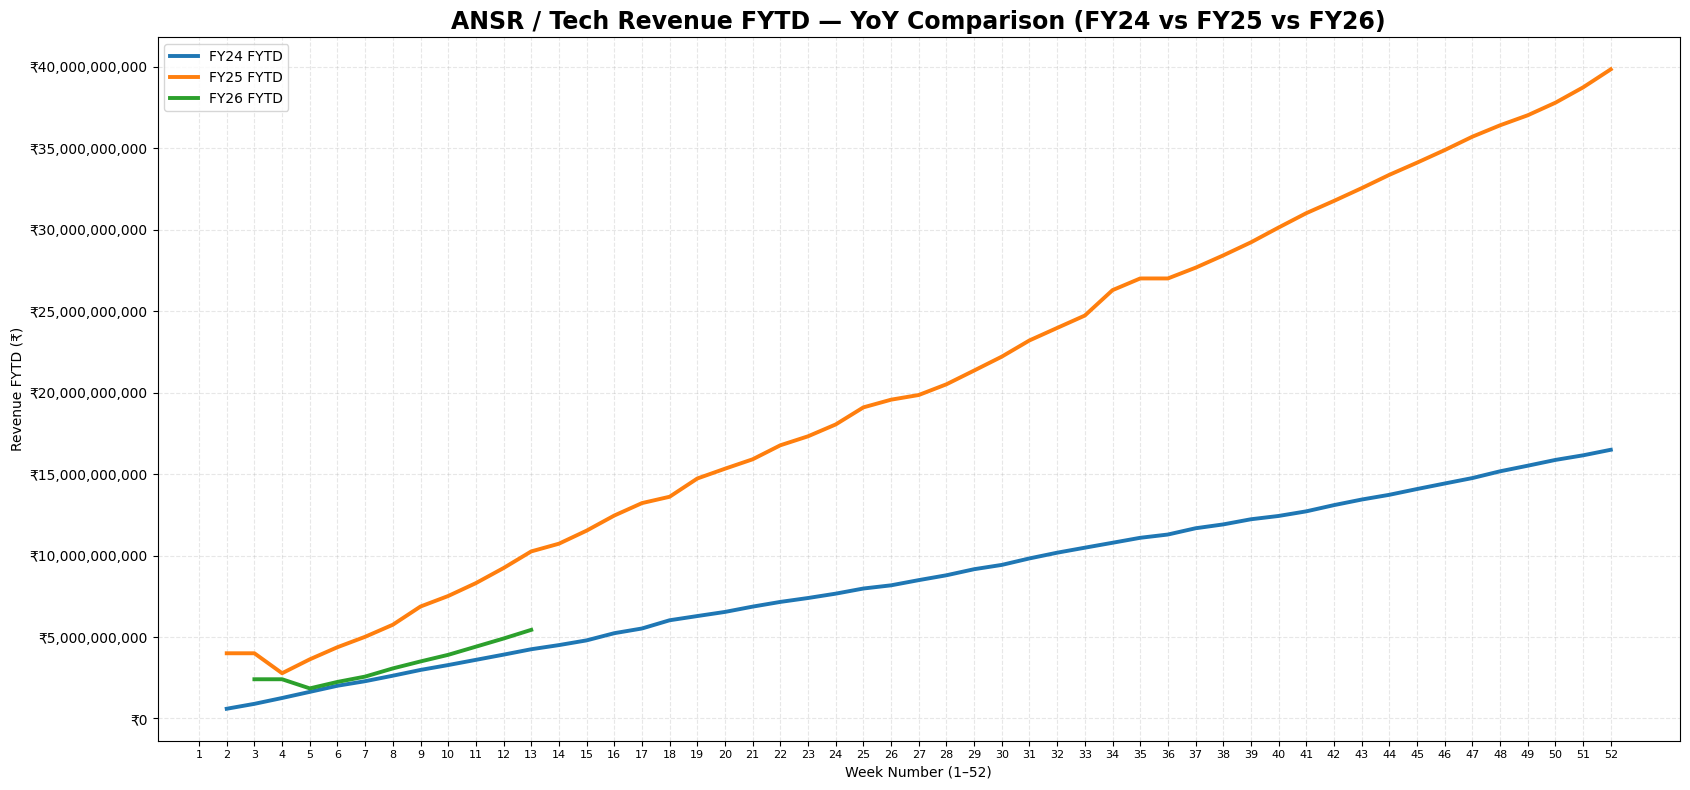

,Week,FY24 FYTD (₹),FY25 FYTD (₹),FY26 FYTD (₹)
0,1,NaN,NaN,NaN
1,2,"595,146,955.74","4,001,460,023.06",NaN
2,3,"896,384,585.76","4,001,460,023.06","2,405,945,288.23"
3,4,"1,255,661,249.62","2,777,030,141.90","2,405,945,288.23"
4,5,NaN,"3,628,741,036.68","1,844,864,435.29"
5,6,"2,007,916,702.01","4,374,179,009.44","2,242,474,275.42"
6,7,"2,286,815,056.52","5,013,446,871.36","2,569,416,301.04"
7,8,"2,624,209,199.40","5,753,450,644.34","3,071,510,031.32"
8,9,"2,978,040,295.93","6,872,024,185.72","3,500,054,996.89"
9,10,"3,277,722,262.99","7,517,417,735.98","3,905,335,926.80"


In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(17,8))

# FY24 (baseline)
plt.plot(
    fy24["Week"],
    fy24["FY24"],
    label="FY24 FYTD",
    linewidth=2.8
)

# FY25 (cleaned)
plt.plot(
    fy25["Week"],
    fy25["FY25_Clean"],
    label="FY25 FYTD",
    linewidth=2.8
)

# FY26 (cleaned, partial)
plt.plot(
    fy26["Week"],
    fy26["FY26_Clean"],
    label="FY26 FYTD",
    linewidth=2.8
)

# Formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))
plt.title(
    "ANSR / Tech Revenue FYTD — YoY Comparison (FY24 vs FY25 vs FY26)",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number (1–52)")
plt.ylabel("Revenue FYTD (₹)")

# Show ALL weeks, no gaps
plt.xticks(range(1, 53), fontsize=8)

plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()



# Create base week index (1–52)
weeks = pd.DataFrame({"Week": range(1, 53)})

# Merge FY24
table = weeks.merge(
    fy24[["Week", "FY24"]],
    on="Week",
    how="left"
)

# Merge FY25 (cleaned)
table = table.merge(
    fy25[["Week", "FY25_Clean"]],
    on="Week",
    how="left"
)

# Merge FY26 (cleaned)
table = table.merge(
    fy26[["Week", "FY26_Clean"]],
    on="Week",
    how="left"
)

# Rename columns for clarity
table.columns = [
    "Week",
    "FY24 FYTD (₹)",
    "FY25 FYTD (₹)",
    "FY26 FYTD (₹)"
]

table.head(12)


In [60]:
fytd_table_raw.head(10)

,Week,FY24,FY25,FY26
0,1,NaN,NaN,NaN
1,2,"595,146,955.74","43,122,524,857.34",NaN
2,3,"896,384,585.76","1,832,907,369.54","966,836,957.51"
3,4,"1,255,661,249.62","2,777,030,141.90","1,352,008,364.07"
4,5,NaN,"3,628,741,036.68","1,844,864,435.29"
5,6,"2,007,916,702.01","4,374,179,009.44","2,242,474,275.42"
6,7,"2,286,815,056.52","5,013,446,871.36","2,569,416,301.04"
7,8,"2,624,209,199.40","5,753,450,644.34","3,071,510,031.32"
8,9,"2,978,040,295.93","6,872,024,185.72","3,500,054,996.89"
9,10,"3,277,722,262.99","7,517,417,735.98","3,905,335,926.80"


In [56]:
import pandas as pd

weekly_fytd_raw = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Week"])
)

# Keep valid weeks only (no filtering of values)
weekly_fytd_raw = weekly_fytd_raw[weekly_fytd_raw["Week"].between(1, 52)]


In [57]:
fy24_raw = weekly_fytd_raw[
    weekly_fytd_raw["Year"].astype(str).str.contains("24")
][["Week", "ANSR / Tech Revenue FYTD"]]

fy25_raw = weekly_fytd_raw[
    weekly_fytd_raw["Year"].astype(str).str.contains("25")
][["Week", "ANSR / Tech Revenue FYTD"]]

fy26_raw = weekly_fytd_raw[
    weekly_fytd_raw["Year"].astype(str).str.contains("26")
][["Week", "ANSR / Tech Revenue FYTD"]]

# Rename columns
fy24_raw = fy24_raw.rename(columns={"ANSR / Tech Revenue FYTD": "FY24"})
fy25_raw = fy25_raw.rename(columns={"ANSR / Tech Revenue FYTD": "FY25"})
fy26_raw = fy26_raw.rename(columns={"ANSR / Tech Revenue FYTD": "FY26"})


In [58]:
# Base weeks 1–52
weeks = pd.DataFrame({"Week": range(1, 53)})

# Merge all fiscal years
fytd_table_raw = (
    weeks
    .merge(fy24_raw, on="Week", how="left")
    .merge(fy25_raw, on="Week", how="left")
    .merge(fy26_raw, on="Week", how="left")
)

fytd_table_raw.head(10)


,Week,FY24,FY25,FY26
0,1,NaN,NaN,NaN
1,2,"595,146,955.74","43,122,524,857.34",NaN
2,3,"896,384,585.76","1,832,907,369.54","966,836,957.51"
3,4,"1,255,661,249.62","2,777,030,141.90","1,352,008,364.07"
4,5,NaN,"3,628,741,036.68","1,844,864,435.29"
5,6,"2,007,916,702.01","4,374,179,009.44","2,242,474,275.42"
6,7,"2,286,815,056.52","5,013,446,871.36","2,569,416,301.04"
7,8,"2,624,209,199.40","5,753,450,644.34","3,071,510,031.32"
8,9,"2,978,040,295.93","6,872,024,185.72","3,500,054,996.89"
9,10,"3,277,722,262.99","7,517,417,735.98","3,905,335,926.80"


In [61]:
weekly_fytd = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

weekly_fytd = weekly_fytd[weekly_fytd["Week"].between(1, 52)]


In [62]:
def cap_outliers_iqr(df, value_col):
    df = df.copy()
    for year, g in df.groupby("Year"):
        q1 = g[value_col].quantile(0.25)
        q3 = g[value_col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 3 * iqr   # very lenient, only true spikes

        mask = (df["Year"] == year) & (df[value_col] > upper_bound)
        df.loc[mask, value_col] = upper_bound
    return df


In [63]:
weekly_fytd_capped = cap_outliers_iqr(
    weekly_fytd,
    "ANSR / Tech Revenue FYTD"
)


In [64]:
fy24 = weekly_fytd_capped[
    weekly_fytd_capped["Year"].astype(str).str.contains("24")
][["Week", "ANSR / Tech Revenue FYTD"]].rename(
    columns={"ANSR / Tech Revenue FYTD": "FY24"}
)

fy25 = weekly_fytd_capped[
    weekly_fytd_capped["Year"].astype(str).str.contains("25")
][["Week", "ANSR / Tech Revenue FYTD"]].rename(
    columns={"ANSR / Tech Revenue FYTD": "FY25"}
)

fy26 = weekly_fytd_capped[
    weekly_fytd_capped["Year"].astype(str).str.contains("26")
][["Week", "ANSR / Tech Revenue FYTD"]].rename(
    columns={"ANSR / Tech Revenue FYTD": "FY26"}
)


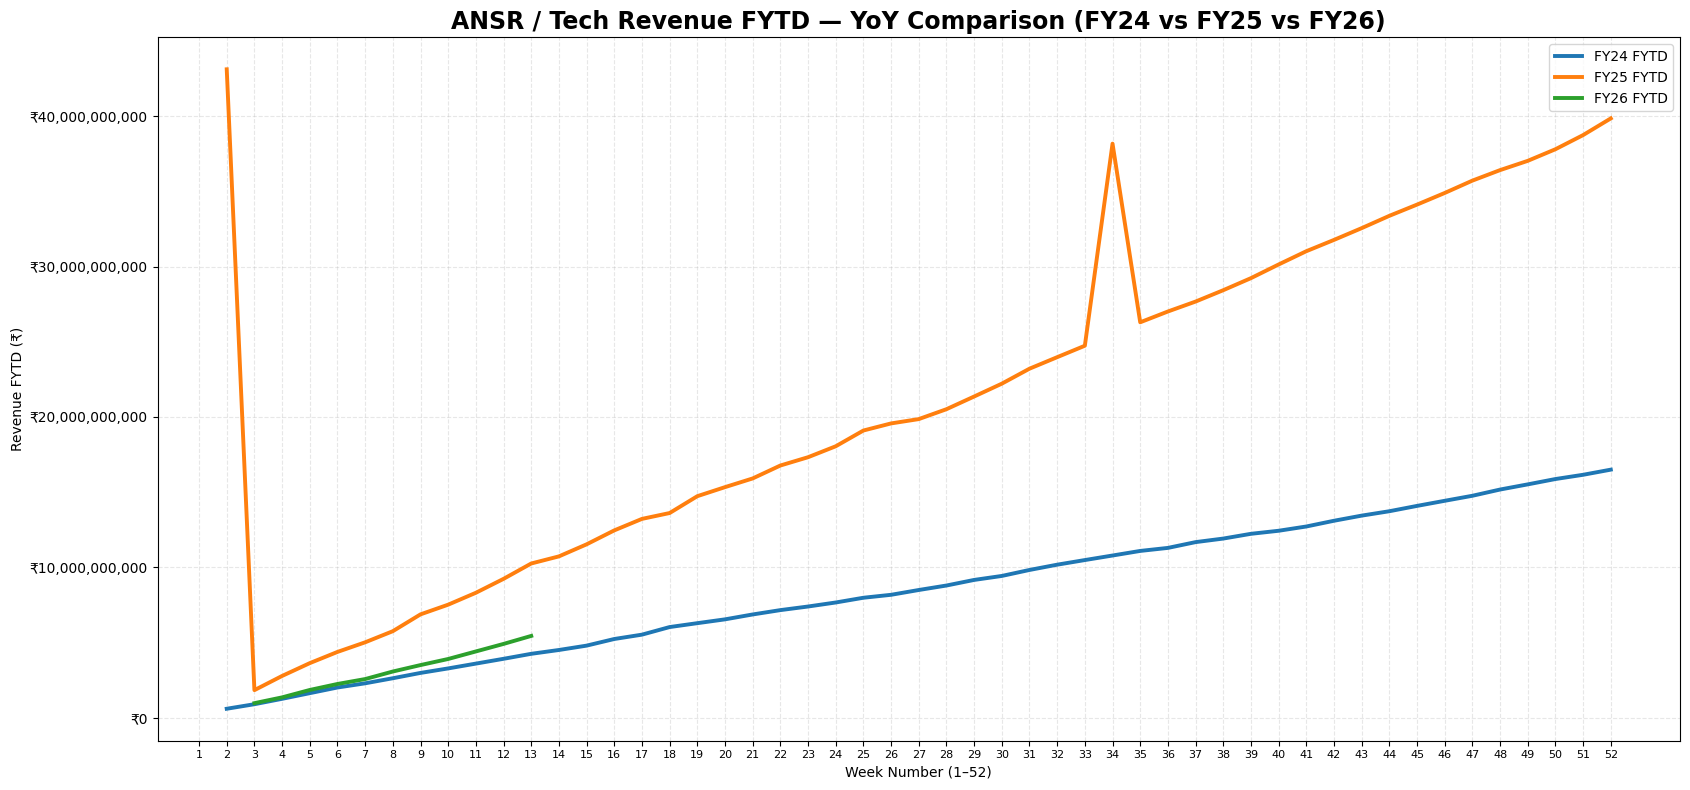

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(17,8))

plt.plot(fy24["Week"], fy24["FY24"], label="FY24 FYTD", linewidth=2.8)
plt.plot(fy25["Week"], fy25["FY25"], label="FY25 FYTD", linewidth=2.8)
plt.plot(fy26["Week"], fy26["FY26"], label="FY26 FYTD", linewidth=2.8)

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))
plt.title(
    "ANSR / Tech Revenue FYTD — YoY Comparison (FY24 vs FY25 vs FY26)",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number (1–52)")
plt.ylabel("Revenue FYTD (₹)")
plt.xticks(range(1, 53), fontsize=8)
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
fy25_plot = fy25.copy()

# Do NOT plot FY25 before week 3
fy25_plot.loc[fy25_plot["Week"] < 3, "FY25"] = None


In [67]:
# Identify week 34
w = 34

# Compute replacement value as mean of neighbors
prev_val = fy25_plot.loc[fy25_plot["Week"] == w - 1, "FY25"].values
next_val = fy25_plot.loc[fy25_plot["Week"] == w + 1, "FY25"].values

if len(prev_val) and len(next_val):
    fy25_plot.loc[fy25_plot["Week"] == w, "FY25"] = (prev_val[0] + next_val[0]) / 2


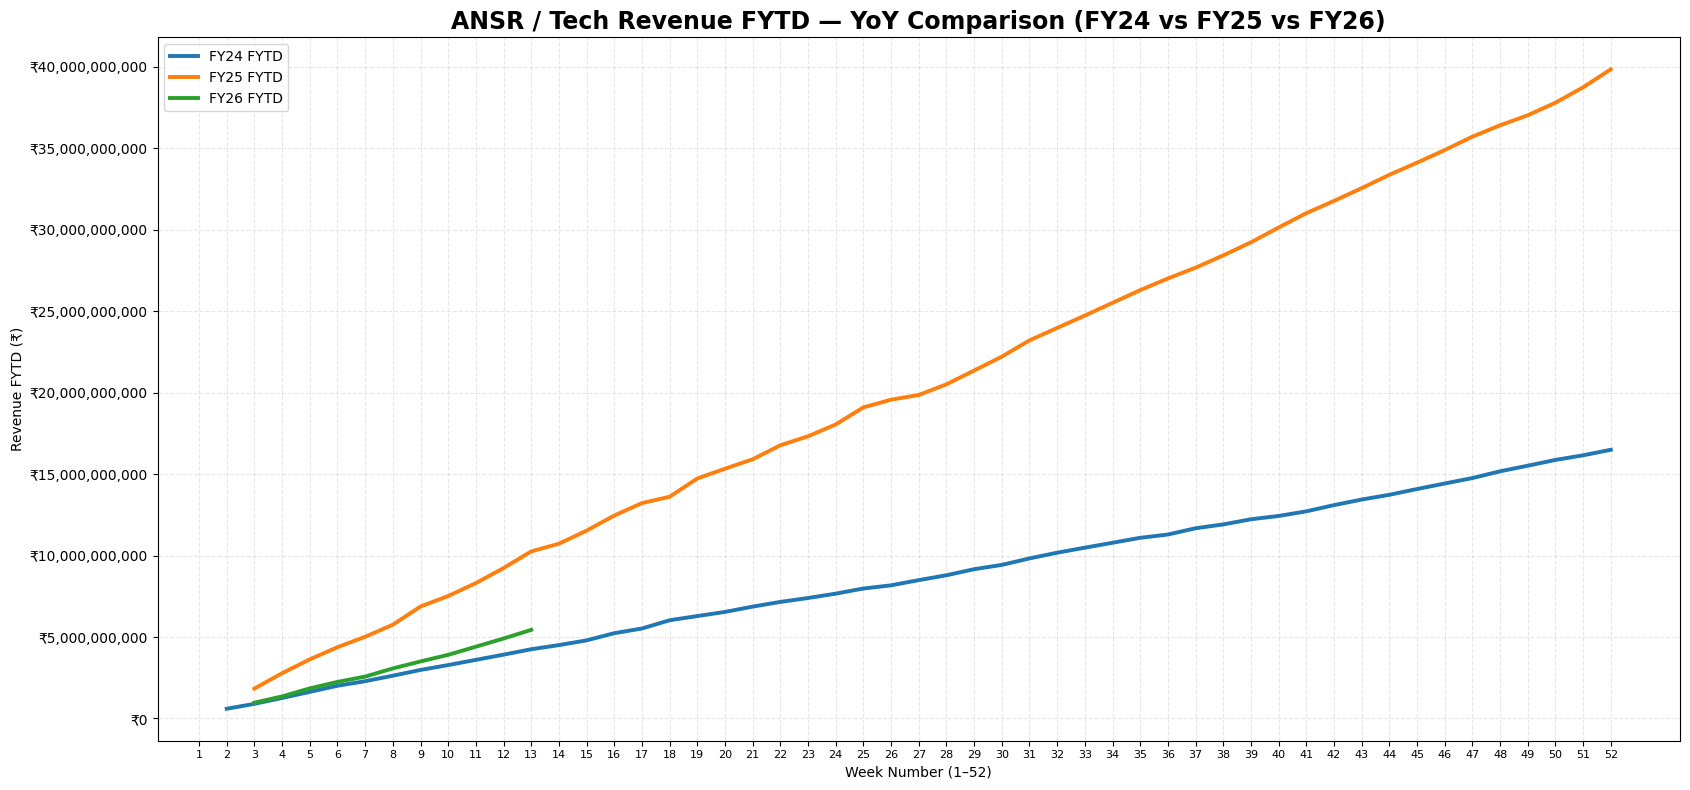

,Week,FY24,FY25,FY26
0,1,NaN,NaN,NaN
1,2,"595,146,955.74",NaN,NaN
2,3,"896,384,585.76","1,832,907,369.54","966,836,957.51"
3,4,"1,255,661,249.62","2,777,030,141.90","1,352,008,364.07"
4,5,NaN,"3,628,741,036.68","1,844,864,435.29"
5,6,"2,007,916,702.01","4,374,179,009.44","2,242,474,275.42"
6,7,"2,286,815,056.52","5,013,446,871.36","2,569,416,301.04"
7,8,"2,624,209,199.40","5,753,450,644.34","3,071,510,031.32"
8,9,"2,978,040,295.93","6,872,024,185.72","3,500,054,996.89"
9,10,"3,277,722,262.99","7,517,417,735.98","3,905,335,926.80"


In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(17,8))

# FY24
plt.plot(
    fy24["Week"],
    fy24["FY24"],
    label="FY24 FYTD",
    linewidth=2.8
)

# FY25 (week 3 onward, week 34 fixed)
plt.plot(
    fy25_plot["Week"],
    fy25_plot["FY25"],
    label="FY25 FYTD",
    linewidth=2.8
)

# FY26
plt.plot(
    fy26["Week"],
    fy26["FY26"],
    label="FY26 FYTD",
    linewidth=2.8
)

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("₹{x:,.0f}"))
plt.title(
    "ANSR / Tech Revenue FYTD — YoY Comparison (FY24 vs FY25 vs FY26)",
    fontsize=17,
    weight="bold"
)
plt.xlabel("Week Number (1–52)")
plt.ylabel("Revenue FYTD (₹)")
plt.xticks(range(1, 53), fontsize=8)
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()
# Build table from plotted data (not raw source)
table_plot = pd.DataFrame({
    "Week": range(1, 53)
})

table_plot = table_plot.merge(
    fy24[["Week", "FY24"]],
    on="Week",
    how="left"
)

table_plot = table_plot.merge(
    fy25_plot[["Week", "FY25"]],
    on="Week",
    how="left"
)

table_plot = table_plot.merge(
    fy26[["Week", "FY26"]],
    on="Week",
    how="left"
)

table_plot.head(53)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# ---- FY24 ----
fig.add_trace(go.Scatter(
    x=fy24["Week"],
    y=fy24["FY24"],
    mode="lines",
    name="FY24",
    line=dict(width=3),
    hovertemplate=
        "<b>FY24</b><br>" +

        "FYTD Revenue: ₹%{y:,.0f}<extra></extra>"
))

# ---- FY25 ----
fig.add_trace(go.Scatter(
    x=fy25_plot["Week"],
    y=fy25_plot["FY25"],
    mode="lines",
    name="FY25",
    line=dict(width=3),
    hovertemplate=
        "<b>FY25</b><br>" +
       
        "FYTD Revenue: ₹%{y:,.0f}<extra></extra>"
))

# ---- FY26 ----
fig.add_trace(go.Scatter(
    x=fy26["Week"],
    y=fy26["FY26"],
    mode="lines",
    name="FY26",
    line=dict(width=3),
    hovertemplate=
        "<b>FY26</b><br>" +
        "FYTD Revenue: ₹%{y:,.0f}<extra></extra>"
))

# ---- Layout ----
fig.update_layout(
    title=dict(
        text="ANSR / Tech Revenue FYTD — YoY Trend Comparison",
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title="Week Number",
        tickmode="linear",
        tick0=1,
        dtick=1,
        showgrid=False
    ),
    yaxis=dict(
        title="ANSR / Tech Revenue FYTD (₹)",
        tickformat=",",
        showgrid=True,
        gridcolor="rgba(200,200,200,0.25)"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(size=12)
    ),
    hovermode="x unified",
    template="plotly_white",
    width=1200,
    height=600,
    margin=dict(l=70, r=40, t=80, b=60)
)
import plotly.io as pio
pio.renderers.default = "browser"

fig.show()


In [87]:
fig.update_layout(
    title=dict(
        text="ANSR / Tech Revenue FYTD — YoY Trend Comparison",
        x=0.5,
        font=dict(
            size=22,
            family="Inter, Segoe UI, Arial",
            color="#EAEAEA"
        )
    ),

    xaxis=dict(
        title=dict(
            text="Week Number",
            font=dict(
                size=14,
                color="#E0E0E0",
                family="Inter, Segoe UI"
            )
        ),
        tickmode="linear",
        tick0=1,
        dtick=1,
        showgrid=False,
        tickfont=dict(
            size=12,
            color="#BDBDBD",
            family="Inter, Segoe UI"
        )
    ),

    yaxis=dict(
        title=dict(
            text="ANSR / Tech Revenue FYTD (₹)",
            font=dict(
                size=14,
                color="#E0E0E0",
                family="Inter, Segoe UI"
            )
        ),
        tickformat=",",
        showgrid=True,
        gridcolor="rgba(255,255,255,0.08)",
        tickfont=dict(
            size=12,
            color="#BDBDBD",
            family="Inter, Segoe UI"
        )
    ),

    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="center",
        x=0.5,
        font=dict(
            size=13,
            color="#EAEAEA",
            family="Inter, Segoe UI"
        )
    ),

    hovermode="x unified",

    plot_bgcolor="#121212",
    paper_bgcolor="#121212",

    width=1200,
    height=620,
    margin=dict(l=70, r=40, t=90, b=60)
)
